# Python Web APIs: Exploring Academic Research with OpenAlex

* * * 

### Icons used in this notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive exercise. We'll work through these in the workshop!<br>
⚠️ **Warning**: Heads-up about tricky stuff or common mistakes.<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
🎬 **Demo**: Showing off something more advanced – so you know what Python can be used for!<br>

### Learning Objectives
1. [Introduction to OpenAlex](#1)
2. [Setting up the OpenAlex API](#2)
3. [Exploring Academic Works (Publications)](#3)
4. [Analyzing Authors](#4)
5. [Analyzing Institutions](#5)
6. [Creating a Research Summary Function](#6)
7. [Open Access Analysis](#7)

<a id='1'></a>

## Import Required Libraries

Let's start by importing all the libraries we'll need:

In [ ]:
# !pip install trafilatura
# !pip install fitz

In [56]:
# Basic libraries for making web requests
import requests
import io
import json
import trafilatura # boilerplate removal tool for web pages
import fitz  # PyMuPDF: fast, lightweight PDF parser

# Data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt

# Utility libraries
from datetime import datetime
import time
from IPython.display import display


## 1. Introduction to OpenAlex

OpenAlex is a **free** and **open** catalog of the global research system. You can find metadata on individual articles, and explore how they connect to each other, who is producing them, and how ideas flow across time, disciplines, and places.

### Why use OpenAlex?
- **240+ million works** from all academic disciplines
- **Completely free** - no API key required!
- **Global coverage** - includes non-English research
- **Rich metadata** - citations, authors, institutions, topics

<a id='2'></a>

## 2. Setting up the OpenAlex API

First, let's set up our basic configuration:

In [ ]:
# Set your email (recommended for polite requests)
EMAIL = "your-email@example.com"  # Replace with your actual email

In [4]:
# Base URL for OpenAlex API
BASE_URL = "https://api.openalex.org"

### Create a Helper Function

This function will make it easier to send requests to OpenAlex:

In [5]:
def make_openalex_request(endpoint, params=None):
    """Make a request to OpenAlex API with proper headers."""
    if params is None:
        params = {}
    
    # Add email to params for polite requests
    params['mailto'] = EMAIL
    
    # Build the full URL
    url = f"{BASE_URL}/{endpoint}"
    
    # Make the request
    response = requests.get(url, params=params)
    
    # Check if successful
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None

### Test the Connection

Let's make sure our connection works:

In [10]:
# Get meta information about OpenAlex
meta_info = make_openalex_request("works", params={'per-page': 1})
meta_info

{'meta': {'count': 270685814,
  'db_response_time_ms': 182,
  'page': 1,
  'per_page': 1,
  'groups_count': None},
 'results': [{'id': 'https://openalex.org/W1775749144',
   'doi': 'https://doi.org/10.1016/s0021-9258(19)52451-6',
   'title': 'PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT',
   'display_name': 'PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT',
   'publication_year': 1951,
   'publication_date': '1951-11-01',
   'ids': {'openalex': 'https://openalex.org/W1775749144',
    'doi': 'https://doi.org/10.1016/s0021-9258(19)52451-6',
    'mag': '1775749144',
    'pmid': 'https://pubmed.ncbi.nlm.nih.gov/14907713'},
   'language': 'en',
   'primary_location': {'is_oa': True,
    'landing_page_url': 'https://doi.org/10.1016/s0021-9258(19)52451-6',
    'pdf_url': None,
    'source': {'id': 'https://openalex.org/S140251998',
     'display_name': 'Journal of Biological Chemistry',
     'issn_l': '0021-9258',
     'issn': ['0021-9258', '1067-8816', '1083-351X'],
     'is_oa': True

In [ ]:
# Display the total number of works
meta_info['meta']['count']

270685814

<a id='3'></a>

## 3. Searching for Academic Works

Works are the central entity in OpenAlex - they represent scholarly documents like journal articles, books, and dissertations.

### Basic Search

Let's search for research on "social media":

In [12]:
# Define our search parameters
search_params = {
    'search': 'social media',
    'per-page': 5  # Get only 5 results to keep it simple
}

In [13]:
# Make the search request
search_results = make_openalex_request('works', params=search_params)

In [14]:
# Display total count
if search_results:
    print(f"Found {search_results['meta']['count']:,} works on 'social media'")

Found 3,204,685 works on 'social media'


### Display Search Results

Let's look at the titles of what we found:

In [20]:
# Display the titles
print("\nTop 5 results:")

for i, work in enumerate(search_results['results'], 1):
    print(f"\n{i}. {work['title']}")


Top 5 results:

1. Users of the world, unite! The challenges and opportunities of Social Media

2. Social Media and Fake News in the 2016 Election

3. Social media? Get serious! Understanding the functional building blocks of social media

4. VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text

5. Social media: The new hybrid element of the promotion mix


### Add More Filters

Let's refine our search to get recent, highly-cited papers:

In [16]:
# Search for recent, highly-cited papers
refined_params = {
    'search': 'social media polarization',
    'filter': 'from_publication_date:2020-01-01',  # Recent works only
    'per-page': 10,
    'sort': 'cited_by_count:desc'  # Sort by most cited
}

In [17]:
# Make the refined search
refined_results = make_openalex_request('works', params=refined_params)

In [21]:
# Display results with more details
print(f"Found {refined_results['meta']['count']:,} works on social media polarization since 2020")
print("\nTop 3 results:")

for i, work in enumerate(refined_results['results'][:3], 1):
    print(f"\n{i}. {work['title']}")
    print(f"   Year: {work['publication_year']}")
    print(f"   Citations: {work['cited_by_count']}")

Found 22,021 works on social media polarization since 2020

Top 3 results:

1. Global, regional, and national burden of stroke and its risk factors, 1990–2019: a systematic analysis for the Global Burden of Disease Study 2019
   Year: 2021
   Citations: 5425

2. Using social and behavioural science to support COVID-19 pandemic response
   Year: 2020
   Citations: 4536

3. Targets of T Cell Responses to SARS-CoV-2 Coronavirus in Humans with COVID-19 Disease and Unexposed Individuals
   Year: 2020
   Citations: 3839


### Examining a Single Work in Detail

Let's look at more details about the most cited paper:

In [22]:
# Get the most cited work
if refined_results and refined_results['results']:
    top_work = refined_results['results'][0]

In [23]:
# Display the title and basic info
print(f"Title: {top_work['title']}")
print(f"Year: {top_work['publication_year']}")
print(f"Type: {top_work['type']}")

Title: Global, regional, and national burden of stroke and its risk factors, 1990–2019: a systematic analysis for the Global Burden of Disease Study 2019
Year: 2021
Type: article


In [24]:
# Display authors
print("\nAuthors:")
for authorship in top_work['authorships'][:3]:  # Show first 3 authors
    author_name = authorship['author']['display_name']
    print(f"  - {author_name}")


Authors:
  - Valery L. Feigin
  - Benjamin Stark
  - Catherine O. Johnson


In [25]:
# Display impact metrics
print(f"\nImpact Metrics:")
print(f"  Citations: {top_work['cited_by_count']}")
print(f"  Open Access: {'Yes' if top_work['open_access']['is_oa'] else 'No'}")


Impact Metrics:
  Citations: 5425
  Open Access: Yes


## 🥊 Challenge 1: Search for Your Topic

Try searching for a topic that interests you. Find:
1. Total number of papers
2. The most cited paper's title and citation count

In [ ]:
# YOUR CODE HERE
# Hint: Use the search parameters we learned above



<a id='4'></a>

## 4. Analyzing Authors

OpenAlex tracks millions of authors. Let's explore author data:

In [26]:
# Search for authors in a field
author_params = {
    'search': 'machine learning',
    'per-page': 5,
    'sort': 'cited_by_count:desc'  # Get most cited authors
}

In [27]:
# Get the authors
top_authors = make_openalex_request('authors', params=author_params)

In [28]:
# Display author information
print("Top Authors in Machine Learning")
print("="*60)

for author in top_authors['results']:
    print(f"\nName: {author['display_name']}")
    print(f"  Works: {author['works_count']:,}")
    print(f"  Citations: {author['cited_by_count']:,}")

Top Authors in Machine Learning

Name: Sonika Tyagi
  Works: 73
  Citations: 1,577

Name: Mojtaba Maghrebi
  Works: 85
  Citations: 1,365

Name: Sangchul Oh
  Works: 78
  Citations: 1,157

Name: Ali Fallah Tehrani
  Works: 27
  Citations: 756

Name: Asharul Islam Khan
  Works: 42
  Citations: 733


### Create a Simple Author Table

Let's organize this data in a table:

In [29]:
# Collect author data
authors_data = []
for author in top_authors['results']:
    authors_data.append({
        'Name': author['display_name'],
        'Works': author['works_count'],
        'Citations': author['cited_by_count']
    })

In [30]:
# Create and display DataFrame
authors_df = pd.DataFrame(authors_data)
display(authors_df)

,Name,Works,Citations
0,Sonika Tyagi,73,1577
1,Mojtaba Maghrebi,85,1365
2,Sangchul Oh,78,1157
3,Ali Fallah Tehrani,27,756
4,Asharul Islam Khan,42,733


<a id='5'></a>

## 5. Analyzing Institutions

Let's look at research institutions:

In [31]:
# Get top institutions
inst_params = {
    'filter': 'type:education',  # Only educational institutions
    'per-page': 10,
    'sort': 'works_count:desc'  # Sort by number of publications
}

In [32]:
# Make the request
top_institutions = make_openalex_request('institutions', params=inst_params)

In [34]:
# Display top 5 institutions
print("Top Research Institutions by Output")

for i, inst in enumerate(top_institutions['results'][:5], 1):
    print(f"\n{i}. {inst['display_name']}")
    print(f"   Country: {inst.get('country_code', 'Unknown')}")
    print(f"   Total Works: {inst['works_count']:,}")

Top Research Institutions by Output

1. Albert Einstein College of Medicine
   Country: US
   Total Works: 93,275

2. Indiana University School of Medicine
   Country: None
   Total Works: 81,379

3. Tokyo University of Science
   Country: JP
   Total Works: 80,788

4. Martin Luther University Halle-Wittenberg
   Country: DE
   Total Works: 70,983

5. Universidade Federal de São Carlos
   Country: BR
   Total Works: 67,716


## Research Trends Over Time

Let's track how a research topic has grown over time:

In [35]:
# Define the topic and years to analyze
topic = "artificial intelligence"
years = [2019, 2020, 2021, 2022, 2023, 2024]

In [36]:
# Collect publication counts for each year
counts = []

for year in years:
    params = {
        'search': topic,
        'filter': f'publication_year:{year}',
        'per-page': 1
    }
    result = make_openalex_request('works', params=params)
    
    if result:
        counts.append(result['meta']['count'])
    else:
        counts.append(0)
    
    # Be polite to the API
    time.sleep(0.1)

In [37]:
# Display the counts
print(f"Publications on '{topic}' by year:")
for year, count in zip(years, counts):
    print(f"  {year}: {count:,}")

Publications on 'artificial intelligence' by year:
  2019: 63,721
  2020: 69,260
  2021: 94,159
  2022: 110,886
  2023: 173,505
  2024: 156,084


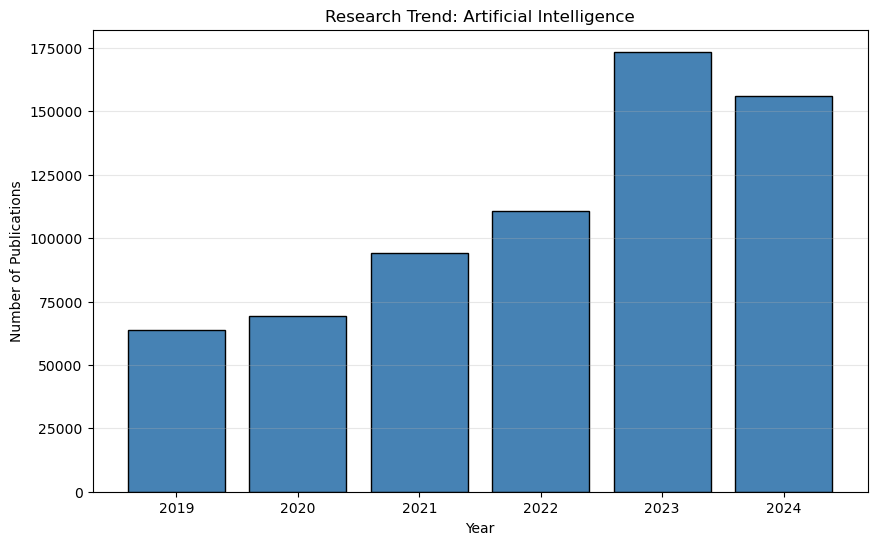

In [38]:
# Create a simple bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, counts, color='steelblue', edgecolor='black')
plt.title(f"Research Trend: {topic.title()}")
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(axis='y', alpha=0.3)
plt.show()

### Comparing Multiple Topics

Let's compare trends for different topics:

In [39]:
# Define topics to compare
topics_to_compare = [
    "machine learning",
    "climate change",
    "social media"
]

In [40]:
# Years to analyze
years = [2020, 2021, 2022, 2023]

In [41]:
# Collect data for all topics
trends_data = {}

for topic in topics_to_compare:
    topic_counts = []
    
    for year in years:
        params = {
            'search': topic,
            'filter': f'publication_year:{year}',
            'per-page': 1
        }
        result = make_openalex_request('works', params=params)
        
        if result:
            topic_counts.append(result['meta']['count'])
        else:
            topic_counts.append(0)
        
        time.sleep(0.1)  # Be polite
    
    trends_data[topic] = topic_counts
    print(f"Collected data for: {topic}")

Collected data for: machine learning
Collected data for: climate change
Collected data for: social media


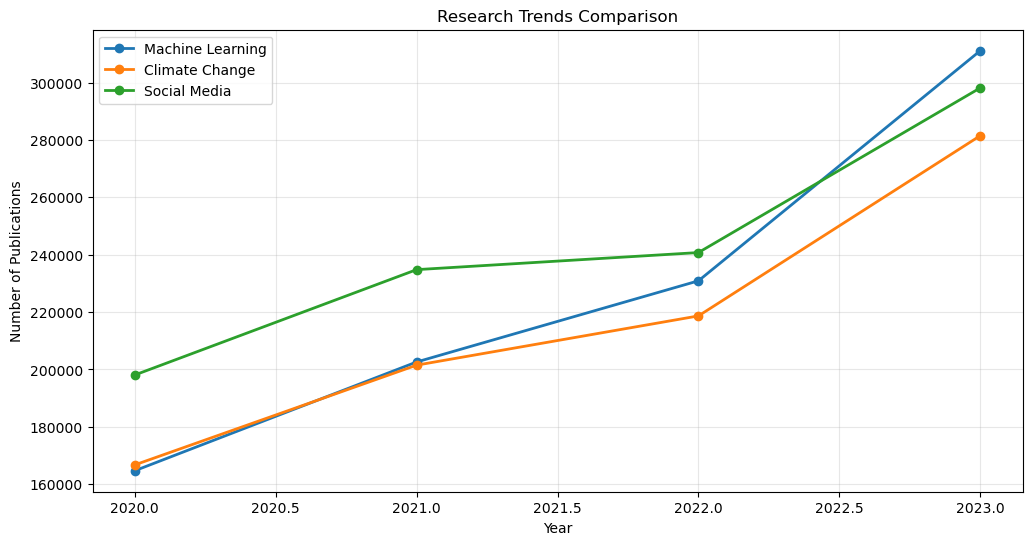

In [42]:
# Plot the comparison
plt.figure(figsize=(12, 6))

for topic, counts in trends_data.items():
    plt.plot(years, counts, marker='o', linewidth=2, label=topic.title())

plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Research Trends Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🥊 Challenge 2: Complete Analysis

Pick a research topic and create a complete analysis:
1. Find the total number of papers
2. Find the top author in this field
3. Plot the trend over the last 3 years

In [ ]:
# YOUR CODE HERE
# Start by defining your topic
my_topic = "your topic here"



<a id='6'></a>

## 6. Creating a Research Summary Function

Let's create a function that summarizes any research topic:

In [ ]:
def research_summary(topic):
    """Create a summary of research on a topic."""
    
    print(f"\n📊 RESEARCH SUMMARY: {topic.upper()}")
    
    # Get total publications
    params = {
        'search': topic,
        'per-page': 1
    }
    result = make_openalex_request('works', params=params)
    
    if result:
        total = result['meta']['count']
        print(f"Total publications: {total:,}")
    
    # Get recent publications
    params['filter'] = 'from_publication_date:2023-01-01'
    recent = make_openalex_request('works', params=params)
    
    if recent:
        recent_count = recent['meta']['count']
        print(f"Publications since 2023: {recent_count:,}")
    
    # Get top cited paper
    params = {
        'search': topic,
        'sort': 'cited_by_count:desc',
        'per-page': 1
    }
    top_paper = make_openalex_request('works', params=params)
    
    if top_paper and top_paper['results']:
        paper = top_paper['results'][0]
        print(f"\nMost cited paper:")
        print(f"  Title: {paper['title'][:60]}...")
        print(f"  Citations: {paper['cited_by_count']:,}")

In [ ]:
# Test the function
research_summary("quantum computing")


📊 RESEARCH SUMMARY: QUANTUM COMPUTING
Total publications: 766,977
Publications since 2023: 72,134

Most cited paper:
  Title: Maximum Likelihood from Incomplete Data Via the <i>EM</i> Al...
  Citations: 47,574


In [ ]:
# Try another topic
research_summary("deep learning")


📊 RESEARCH SUMMARY: DEEP LEARNING
Total publications: 2,550,300
Publications since 2023: 643,020

Most cited paper:
  Title: Deep Residual Learning for Image Recognition...
  Citations: 193,757


<a id='7'></a>

## 7. Open Access Analysis

So far we’ve looked at how OpenAlex gives us **metadata** (titles, authors, DOIs, etc.).  
But OpenAlex also tells us where to find the **full text** of open-access papers.  

The goal is to show how you can move from *metadata* → *full text* → *analysis* with only a few lines of code.

Let's first analyze what percentage of papers are open access:

In [72]:
topic = "data science"

def count(filter_extra=""):
    params = {
        "search": topic,
        "filter": f"from_publication_date:2023-01-01{filter_extra}",
        "per-page": 1
    }
    return requests.get(f"{BASE}/works", params=params).json()["meta"]["count"]

total = count()
oa = count(",is_oa:true")
pct = (oa / total) * 100 if total else 0

print(f"Analysis for '{topic}' (2023–present):")
print(f"  Total papers: {total:,}")
print(f"  Open Access papers: {oa:,}")
print(f"  Open Access percentage: {pct:.1f}%")

Analysis for 'data science' (2023–present):
  Total papers: 964,370
  Open Access papers: 877,511
  Open Access percentage: 91.0%


Now, let's build a tiny pipeline to:

1. **Search** OpenAlex for recent open-access works on a topic (e.g., *machine learning*)
2. **Pick** a PDF link from the metadata
3. **Download** the PDF and **extract plain text** from it
4. **Repeat** this process for a few papers, to show how you could scale up

Note that we're simplifying things here. The code only looks for PDFs (not HTML), stops after a few papers, and our text extraction is lightweight (no formatting, just collapsed whitespace).

In [68]:
def search_oa_works(topic, from_date="2023-01-01", per_page=50):
    """
    Query OpenAlex for works on a given topic.
    - topic: search string (e.g. "machine learning")
    - from_date: only get works published after this date
    - per_page: number of results to fetch (max 200)
    """
    url = f"{BASE}/works"
    params = {
        "search": topic,
        "filter": f"from_publication_date:{from_date},is_oa:true",  # only open access
        "per_page": per_page,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()["results"]

def pick_pdf_url(work):
    """
    Try to find a direct PDF link in the work metadata.
    Checks best_oa_location first, then the generic open_access field.
    Returns None if no PDF-looking URL is found.
    """
    bol = work.get("best_oa_location") or {}
    candidates = [bol.get("url_for_pdf"), bol.get("url")]
    oa = (work.get("open_access") or {}).get("oa_url")
    if oa: 
        candidates.append(oa)
    for u in candidates:
        if u and u.lower().split("?", 1)[0].endswith(".pdf"):
            return u
    return None

def pdf_to_text(url):
    """
    Download a PDF from the given URL and extract its text.
    Uses PyMuPDF (fitz) for reliable PDF parsing.
    Then collapses extra whitespace into single spaces.
    """
    r = requests.get(url, headers={"User-Agent": "OpenAlex-demo"}, timeout=60)
    r.raise_for_status()
    with io.BytesIO(r.content) as buf, fitz.open(stream=buf, filetype="pdf") as doc:
        raw = "\n".join(p.get_text() for p in doc)
    return " ".join(raw.split())

def harvest_texts(topic, k=5, from_date="2023-01-01", per_page=100):
    """
    Collect up to k open-access PDFs for a given topic and return their text.
    - topic: what to search for in OpenAlex
    - k: how many papers you want
    - from_date: publication cutoff
    - per_page: how many results to request per API call
    """
    out = []
    for w in search_oa_works(topic, from_date=from_date, per_page=per_page):
        if len(out) >= k:  # stop once we have enough
            break
        pdf = pick_pdf_url(w)
        if not pdf:
            continue
        try:
            text = pdf_to_text(pdf)
            if not text:
                continue
            out.append({
                "title": w.get("title"),
                "pdf_url": pdf,
                "text": text,
            })
        except Exception:
            # keep it simple: skip any failures and move on
            continue
    return out

In [69]:
# Grab 3 recent machine learning papers and preview their text
results = harvest_texts(topic="machine learning", k=3, from_date="2023-01-01")
for i, r in enumerate(results, 1):
    print(f"{i}. {r['title']}")
    print(r["pdf_url"])
    print(r["text"][:500], "\n")  # preview first 500 characters

1. Small data machine learning in materials science
https://www.nature.com/articles/s41524-023-01000-z.pdf
REVIEW ARTICLE OPEN Small data machine learning in materials science Pengcheng Xu1, Xiaobo Ji2, Minjie Li 2✉and Wencong Lu 1,2,3✉ This review discussed the dilemma of small data faced by materials machine learning. First, we analyzed the limitations brought by small data. Then, the workﬂow of materials machine learning has been introduced. Next, the methods of dealing with small data were introduced, including data extraction from publications, materials database construction, high-throughput co 

2. Evaluation metrics and statistical tests for machine learning
https://www.nature.com/articles/s41598-024-56706-x.pdf
1 Vol.:(0123456789) Scientific Reports | (2024) 14:6086 | https://doi.org/10.1038/s41598-024-56706-x www.nature.com/scientificreports Evaluation metrics and statistical tests for machine learning Oona Rainio *, Jarmo Teuho & Riku Klén Research on different machine learn

## Key Takeaways

### What we learned:

1. **OpenAlex basics**
   - Free API with no key required
   - Access to 240+ million scholarly works

2. **Core entities**
   - Works (publications)
   - Authors
   - Institutions
   - Topics

3. **Key API parameters**
   - `search`: Find content by keywords
   - `filter`: Apply specific criteria
   - `sort`: Order results
   - `per-page`: Control result size

4. **Analysis possibilities**
   - Track research trends
   - Analyze citation impact
   - Study collaboration networks
   - Monitor open access adoption
   - Download and read open access papers

### Next steps:
- Explore other filters (institution, country, funding)
- Build collaboration networks
- Create citation analysis tools
- Track emerging research areas

## 💡 Tips for Using OpenAlex

1. **Be polite**: Include your email and add delays between requests
2. **Use filters**: They make your searches much more efficient
3. **Start small**: Test with small result sets before scaling up
4. **Check the docs**: https://docs.openalex.org for all available options
5. **Rate limits**: 100,000 requests/day, max 10/second